In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

%matplotlib inline

warnings.filterwarnings('ignore')
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)

plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

# IHDP semi-synthetic dataset

Hill introduced a semi-synthetic dataset constructed from the Infant Health
and Development Program (IHDP). This dataset is based on a randomized experiment
investigating the effect of home visits by specialists on future cognitive scores. The IHDP simulation is considered the de-facto standard benchmark for neural network treatment effect
estimation methods.

In [2]:
# load all ihadp data
df = pd.DataFrame()
for i in range(1, 10):
    data = pd.read_csv('./data/ihdp_npci_' + str(i) + '.csv', header=None)
    df = pd.concat([data, df])
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
df.columns = cols
print(df.shape)

# replicate the data 100 times
replications = 100
df = pd.concat([df]*replications, ignore_index=True)
print(df.shape)

(6723, 30)
(672300, 30)


In [3]:
# set which features are binary
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# set which features are continuous
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features with binary first and continuous after
perm = binfeats + contfeats

In [4]:
df = df.reset_index(drop=True)
df.head()

,treatment,y_factual,y_cfactual,mu0,mu1,0,1,2,3,4,...,15,16,17,18,19,20,21,22,23,24
0,1,49.647921,34.950762,37.173291,50.383798,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,16.073412,49.435313,16.087249,49.546234,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,19.643007,48.598210,18.044855,49.661068,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,26.368322,49.715204,24.605964,49.971196,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,20.258893,51.147418,20.612816,49.794120,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [5]:
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

In [6]:
# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

## CEVAE Model

In [7]:
# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

In [8]:
cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

In [9]:
# fit
losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

INFO 	 Training with 538 minibatches per epoch
DEBUG 	 step     0 loss = 1021.35
DEBUG 	 step     1 loss = 421.484
DEBUG 	 step     2 loss = 338.296
DEBUG 	 step     3 loss = 319.514
DEBUG 	 step     4 loss = 217.484
DEBUG 	 step     5 loss = 237.474
DEBUG 	 step     6 loss = 242.367
DEBUG 	 step     7 loss = 236.713
DEBUG 	 step     8 loss = 200.399
DEBUG 	 step     9 loss = 201.788
DEBUG 	 step    10 loss = 220.049
DEBUG 	 step    11 loss = 213.79
DEBUG 	 step    12 loss = 190.921
DEBUG 	 step    13 loss = 196.359
DEBUG 	 step    14 loss = 189.747
DEBUG 	 step    15 loss = 167.321
DEBUG 	 step    16 loss = 159.207
DEBUG 	 step    17 loss = 154.599
DEBUG 	 step    18 loss = 150.961
DEBUG 	 step    19 loss = 149.938
DEBUG 	 step    20 loss = 134.768
DEBUG 	 step    21 loss = 140.833
DEBUG 	 step    22 loss = 146.769
DEBUG 	 step    23 loss = 132.524
DEBUG 	 step    24 loss = 134.194
DEBUG 	 step    25 loss = 130.618
DEBUG 	 step    26 loss = 136.787
DEBUG 	 step    27 loss = 126.727
DE

DEBUG 	 step   241 loss = 22.3578
DEBUG 	 step   242 loss = 23.3638
DEBUG 	 step   243 loss = 22.1094
DEBUG 	 step   244 loss = 22.1056
DEBUG 	 step   245 loss = 22.1651
DEBUG 	 step   246 loss = 21.4072
DEBUG 	 step   247 loss = 21.4627
DEBUG 	 step   248 loss = 21.2096
DEBUG 	 step   249 loss = 21.3499
DEBUG 	 step   250 loss = 21.4386
DEBUG 	 step   251 loss = 21.3385
DEBUG 	 step   252 loss = 21.3782
DEBUG 	 step   253 loss = 20.7455
DEBUG 	 step   254 loss = 22.3244
DEBUG 	 step   255 loss = 21.1068
DEBUG 	 step   256 loss = 21.5648
DEBUG 	 step   257 loss = 21.5746
DEBUG 	 step   258 loss = 21.6169
DEBUG 	 step   259 loss = 21.2303
DEBUG 	 step   260 loss = 21.8207
DEBUG 	 step   261 loss = 21.2217
DEBUG 	 step   262 loss = 22.4259
DEBUG 	 step   263 loss = 21.2911
DEBUG 	 step   264 loss = 21.9783
DEBUG 	 step   265 loss = 120.585
DEBUG 	 step   266 loss = 22.3958
DEBUG 	 step   267 loss = 21.1204
DEBUG 	 step   268 loss = 20.3405
DEBUG 	 step   269 loss = 19.9695
DEBUG 	 step  

DEBUG 	 step   483 loss = 13.2939
DEBUG 	 step   484 loss = 13.3987
DEBUG 	 step   485 loss = 13.4694
DEBUG 	 step   486 loss = 13.0736
DEBUG 	 step   487 loss = 12.9663
DEBUG 	 step   488 loss = 13.4017
DEBUG 	 step   489 loss = 13.1387
DEBUG 	 step   490 loss = 12.8554
DEBUG 	 step   491 loss = 13.7535
DEBUG 	 step   492 loss = 13.0516
DEBUG 	 step   493 loss = 12.9229
DEBUG 	 step   494 loss = 13.0794
DEBUG 	 step   495 loss = 12.6742
DEBUG 	 step   496 loss = 12.5159
DEBUG 	 step   497 loss = 13.8863
DEBUG 	 step   498 loss = 13.275
DEBUG 	 step   499 loss = 13.8195
DEBUG 	 step   500 loss = 14.2111
DEBUG 	 step   501 loss = 12.8113
DEBUG 	 step   502 loss = 13.5611
DEBUG 	 step   503 loss = 13.1597
DEBUG 	 step   504 loss = 12.7698
DEBUG 	 step   505 loss = 12.655
DEBUG 	 step   506 loss = 13.3424
DEBUG 	 step   507 loss = 13.0807
DEBUG 	 step   508 loss = 13.4257
DEBUG 	 step   509 loss = 12.769
DEBUG 	 step   510 loss = 13.2426
DEBUG 	 step   511 loss = 13.7624
DEBUG 	 step   51

DEBUG 	 step   725 loss = 8.71019
DEBUG 	 step   726 loss = 9.34067
DEBUG 	 step   727 loss = 8.33531
DEBUG 	 step   728 loss = 8.50657
DEBUG 	 step   729 loss = 7.92335
DEBUG 	 step   730 loss = 8.73418
DEBUG 	 step   731 loss = 7.50367
DEBUG 	 step   732 loss = 8.30074
DEBUG 	 step   733 loss = 8.10457
DEBUG 	 step   734 loss = 8.57933
DEBUG 	 step   735 loss = 8.29648
DEBUG 	 step   736 loss = 9.08495
DEBUG 	 step   737 loss = 9.19558
DEBUG 	 step   738 loss = 7.57463
DEBUG 	 step   739 loss = 8.25734
DEBUG 	 step   740 loss = 8.1562
DEBUG 	 step   741 loss = 8.13552
DEBUG 	 step   742 loss = 8.61787
DEBUG 	 step   743 loss = 7.84507
DEBUG 	 step   744 loss = 8.50339
DEBUG 	 step   745 loss = 9.99432
DEBUG 	 step   746 loss = 8.67392
DEBUG 	 step   747 loss = 7.62062
DEBUG 	 step   748 loss = 8.47083
DEBUG 	 step   749 loss = 7.59856
DEBUG 	 step   750 loss = 8.73944
DEBUG 	 step   751 loss = 7.82123
DEBUG 	 step   752 loss = 8.3673
DEBUG 	 step   753 loss = 8.05969
DEBUG 	 step   7

DEBUG 	 step   967 loss = 4.89925
DEBUG 	 step   968 loss = 5.95339
DEBUG 	 step   969 loss = 5.41167
DEBUG 	 step   970 loss = 5.61495
DEBUG 	 step   971 loss = 6.08719
DEBUG 	 step   972 loss = 5.70671
DEBUG 	 step   973 loss = 6.29176
DEBUG 	 step   974 loss = 5.96967
DEBUG 	 step   975 loss = 5.64207
DEBUG 	 step   976 loss = 6.11389
DEBUG 	 step   977 loss = 5.4677
DEBUG 	 step   978 loss = 5.26326
DEBUG 	 step   979 loss = 5.63665
DEBUG 	 step   980 loss = 5.47218
DEBUG 	 step   981 loss = 5.76207
DEBUG 	 step   982 loss = 5.25431
DEBUG 	 step   983 loss = 5.11318
DEBUG 	 step   984 loss = 5.23281
DEBUG 	 step   985 loss = 4.9322
DEBUG 	 step   986 loss = 5.19766
DEBUG 	 step   987 loss = 5.32089
DEBUG 	 step   988 loss = 5.56581
DEBUG 	 step   989 loss = 5.68178
DEBUG 	 step   990 loss = 4.37302
DEBUG 	 step   991 loss = 5.50948
DEBUG 	 step   992 loss = 5.3806
DEBUG 	 step   993 loss = 6.08309
DEBUG 	 step   994 loss = 5.74113
DEBUG 	 step   995 loss = 5.29156
DEBUG 	 step   99

DEBUG 	 step  1209 loss = 3.79127
DEBUG 	 step  1210 loss = 3.59221
DEBUG 	 step  1211 loss = 3.88194
DEBUG 	 step  1212 loss = 3.40576
DEBUG 	 step  1213 loss = 3.87329
DEBUG 	 step  1214 loss = 3.49796
DEBUG 	 step  1215 loss = 3.24266
DEBUG 	 step  1216 loss = 3.73337
DEBUG 	 step  1217 loss = 3.64298
DEBUG 	 step  1218 loss = 3.20159
DEBUG 	 step  1219 loss = 2.85318
DEBUG 	 step  1220 loss = 3.73986
DEBUG 	 step  1221 loss = 3.01543
DEBUG 	 step  1222 loss = 3.32277
DEBUG 	 step  1223 loss = 2.74171
DEBUG 	 step  1224 loss = 3.70805
DEBUG 	 step  1225 loss = 3.61112
DEBUG 	 step  1226 loss = 2.88479
DEBUG 	 step  1227 loss = 3.65801
DEBUG 	 step  1228 loss = 4.02943
DEBUG 	 step  1229 loss = 2.83562
DEBUG 	 step  1230 loss = 3.24228
DEBUG 	 step  1231 loss = 3.2782
DEBUG 	 step  1232 loss = 3.59486
DEBUG 	 step  1233 loss = 3.65803
DEBUG 	 step  1234 loss = 2.6809
DEBUG 	 step  1235 loss = 3.3619
DEBUG 	 step  1236 loss = 3.39297
DEBUG 	 step  1237 loss = 3.81023
DEBUG 	 step  123

DEBUG 	 step  1451 loss = 2.23005
DEBUG 	 step  1452 loss = 2.05846
DEBUG 	 step  1453 loss = 2.37242
DEBUG 	 step  1454 loss = 1.70136
DEBUG 	 step  1455 loss = 2.47376
DEBUG 	 step  1456 loss = 2.62243
DEBUG 	 step  1457 loss = 2.22
DEBUG 	 step  1458 loss = 2.60625
DEBUG 	 step  1459 loss = 1.61209
DEBUG 	 step  1460 loss = 2.40373
DEBUG 	 step  1461 loss = 3.32855
DEBUG 	 step  1462 loss = 2.61678
DEBUG 	 step  1463 loss = 3.63504
DEBUG 	 step  1464 loss = 2.30637
DEBUG 	 step  1465 loss = 2.62554
DEBUG 	 step  1466 loss = 2.52577
DEBUG 	 step  1467 loss = 2.04929
DEBUG 	 step  1468 loss = 2.80166
DEBUG 	 step  1469 loss = 2.27281
DEBUG 	 step  1470 loss = 2.53645
DEBUG 	 step  1471 loss = 2.23338
DEBUG 	 step  1472 loss = 2.09672
DEBUG 	 step  1473 loss = 2.42459
DEBUG 	 step  1474 loss = 2.39755
DEBUG 	 step  1475 loss = 2.70626
DEBUG 	 step  1476 loss = 2.14803
DEBUG 	 step  1477 loss = 2.12395
DEBUG 	 step  1478 loss = 2.0754
DEBUG 	 step  1479 loss = 2.52702
DEBUG 	 step  1480

DEBUG 	 step  1693 loss = 1.73022
DEBUG 	 step  1694 loss = 0.660628
DEBUG 	 step  1695 loss = 1.47228
DEBUG 	 step  1696 loss = 1.16098
DEBUG 	 step  1697 loss = 1.3503
DEBUG 	 step  1698 loss = 1.31396
DEBUG 	 step  1699 loss = 2.02182
DEBUG 	 step  1700 loss = 0.960196
DEBUG 	 step  1701 loss = 1.45575
DEBUG 	 step  1702 loss = 1.09297
DEBUG 	 step  1703 loss = 1.27731
DEBUG 	 step  1704 loss = 1.63084
DEBUG 	 step  1705 loss = 1.46701
DEBUG 	 step  1706 loss = 1.58075
DEBUG 	 step  1707 loss = 2.77646
DEBUG 	 step  1708 loss = 1.66917
DEBUG 	 step  1709 loss = 1.53974
DEBUG 	 step  1710 loss = 0.746076
DEBUG 	 step  1711 loss = 0.787667
DEBUG 	 step  1712 loss = 1.48705
DEBUG 	 step  1713 loss = 1.15223
DEBUG 	 step  1714 loss = 0.74432
DEBUG 	 step  1715 loss = 1.20326
DEBUG 	 step  1716 loss = 1.05584
DEBUG 	 step  1717 loss = 1.25595
DEBUG 	 step  1718 loss = 1.63639
DEBUG 	 step  1719 loss = 1.18738
DEBUG 	 step  1720 loss = 0.997565
DEBUG 	 step  1721 loss = 1.59334
DEBUG 	 st

DEBUG 	 step  1931 loss = 0.544337
DEBUG 	 step  1932 loss = 0.729942
DEBUG 	 step  1933 loss = 0.281568
DEBUG 	 step  1934 loss = 0.746916
DEBUG 	 step  1935 loss = 0.731851
DEBUG 	 step  1936 loss = 0.861581
DEBUG 	 step  1937 loss = 0.587285
DEBUG 	 step  1938 loss = 0.375893
DEBUG 	 step  1939 loss = 0.52338
DEBUG 	 step  1940 loss = 0.0507239
DEBUG 	 step  1941 loss = 0.544204
DEBUG 	 step  1942 loss = 0.139653
DEBUG 	 step  1943 loss = 0.603852
DEBUG 	 step  1944 loss = 0.591492
DEBUG 	 step  1945 loss = 0.211932
DEBUG 	 step  1946 loss = 0.632158
DEBUG 	 step  1947 loss = 0.613739
DEBUG 	 step  1948 loss = 1.12637
DEBUG 	 step  1949 loss = 0.655486
DEBUG 	 step  1950 loss = 0.687108
DEBUG 	 step  1951 loss = 0.224532
DEBUG 	 step  1952 loss = 0.675569
DEBUG 	 step  1953 loss = 1.16836
DEBUG 	 step  1954 loss = 0.575642
DEBUG 	 step  1955 loss = 0.314398
DEBUG 	 step  1956 loss = 0.949717
DEBUG 	 step  1957 loss = 1.06026
DEBUG 	 step  1958 loss = 0.894075
DEBUG 	 step  1959 loss

DEBUG 	 step  2163 loss = -0.341321
DEBUG 	 step  2164 loss = -0.0973744
DEBUG 	 step  2165 loss = 0.335691
DEBUG 	 step  2166 loss = -0.513224
DEBUG 	 step  2167 loss = 0.441127
DEBUG 	 step  2168 loss = -0.195149
DEBUG 	 step  2169 loss = -0.155654
DEBUG 	 step  2170 loss = 0.146065
DEBUG 	 step  2171 loss = -0.157879
DEBUG 	 step  2172 loss = 0.427397
DEBUG 	 step  2173 loss = -0.264271
DEBUG 	 step  2174 loss = 0.255104
DEBUG 	 step  2175 loss = 0.143516
DEBUG 	 step  2176 loss = -0.144723
DEBUG 	 step  2177 loss = 0.362921
DEBUG 	 step  2178 loss = 0.085199
DEBUG 	 step  2179 loss = 0.166598
DEBUG 	 step  2180 loss = -0.529532
DEBUG 	 step  2181 loss = -0.318048
DEBUG 	 step  2182 loss = -0.0852365
DEBUG 	 step  2183 loss = -0.226952
DEBUG 	 step  2184 loss = 0.372169
DEBUG 	 step  2185 loss = 0.46677
DEBUG 	 step  2186 loss = -0.0550372
DEBUG 	 step  2187 loss = 0.123473
DEBUG 	 step  2188 loss = -0.709439
DEBUG 	 step  2189 loss = 0.627293
DEBUG 	 step  2190 loss = -0.932047
DEB

DEBUG 	 step  2393 loss = -0.0789079
DEBUG 	 step  2394 loss = -0.146879
DEBUG 	 step  2395 loss = -0.162622
DEBUG 	 step  2396 loss = -0.580962
DEBUG 	 step  2397 loss = -0.704767
DEBUG 	 step  2398 loss = -0.471613
DEBUG 	 step  2399 loss = -0.18096
DEBUG 	 step  2400 loss = -0.162947
DEBUG 	 step  2401 loss = 0.0571842
DEBUG 	 step  2402 loss = -0.707115
DEBUG 	 step  2403 loss = -0.812926
DEBUG 	 step  2404 loss = 0.680889
DEBUG 	 step  2405 loss = 0.158955
DEBUG 	 step  2406 loss = -0.636955
DEBUG 	 step  2407 loss = -0.821936
DEBUG 	 step  2408 loss = 0.0161349
DEBUG 	 step  2409 loss = 2.05343
DEBUG 	 step  2410 loss = -0.449846
DEBUG 	 step  2411 loss = -0.112297
DEBUG 	 step  2412 loss = 0.23516
DEBUG 	 step  2413 loss = 0.598729
DEBUG 	 step  2414 loss = -0.637791
DEBUG 	 step  2415 loss = -0.0771543
DEBUG 	 step  2416 loss = -0.720933
DEBUG 	 step  2417 loss = -0.324247
DEBUG 	 step  2418 loss = -0.615081
DEBUG 	 step  2419 loss = -0.489061
DEBUG 	 step  2420 loss = -0.81913

DEBUG 	 step  2622 loss = -0.661252
DEBUG 	 step  2623 loss = -0.774471
DEBUG 	 step  2624 loss = -1.18561
DEBUG 	 step  2625 loss = -0.275053
DEBUG 	 step  2626 loss = -0.887767
DEBUG 	 step  2627 loss = 0.287073
DEBUG 	 step  2628 loss = -0.905378
DEBUG 	 step  2629 loss = 0.0570901
DEBUG 	 step  2630 loss = -0.351999
DEBUG 	 step  2631 loss = -0.118707
DEBUG 	 step  2632 loss = -0.671623
DEBUG 	 step  2633 loss = -0.681996
DEBUG 	 step  2634 loss = -0.521377
DEBUG 	 step  2635 loss = -0.617793
DEBUG 	 step  2636 loss = -0.603524
DEBUG 	 step  2637 loss = -0.821486
DEBUG 	 step  2638 loss = -0.356088
DEBUG 	 step  2639 loss = -0.536534
DEBUG 	 step  2640 loss = -0.747998
DEBUG 	 step  2641 loss = -0.439992
DEBUG 	 step  2642 loss = -0.0627628
DEBUG 	 step  2643 loss = 0.331022
DEBUG 	 step  2644 loss = -0.441603
DEBUG 	 step  2645 loss = -0.515788
DEBUG 	 step  2646 loss = -0.475961
DEBUG 	 step  2647 loss = -0.401744
DEBUG 	 step  2648 loss = 0.262217
DEBUG 	 step  2649 loss = -0.83

In [10]:
# predict
ite_train = cevae.predict(X_train)
ite_val = cevae.predict(X_val)

INFO 	 Evaluating 538 minibatches
DEBUG 	 batch ate = 0.62191
DEBUG 	 batch ate = 0.613137
DEBUG 	 batch ate = 0.688279
DEBUG 	 batch ate = 0.530233
DEBUG 	 batch ate = 0.814089
DEBUG 	 batch ate = 0.623182
DEBUG 	 batch ate = 0.657884
DEBUG 	 batch ate = 0.594205
DEBUG 	 batch ate = 0.319953
DEBUG 	 batch ate = 0.557599
DEBUG 	 batch ate = 0.718177
DEBUG 	 batch ate = 0.441256
DEBUG 	 batch ate = 0.654653
DEBUG 	 batch ate = 0.70725
DEBUG 	 batch ate = 0.715862
DEBUG 	 batch ate = 0.193786
DEBUG 	 batch ate = 0.557451
DEBUG 	 batch ate = 0.788378
DEBUG 	 batch ate = 0.605489
DEBUG 	 batch ate = 0.669786
DEBUG 	 batch ate = 0.852794
DEBUG 	 batch ate = 0.755987
DEBUG 	 batch ate = 0.510262
DEBUG 	 batch ate = 0.502153
DEBUG 	 batch ate = 0.254691
DEBUG 	 batch ate = 0.369999
DEBUG 	 batch ate = 0.59401
DEBUG 	 batch ate = 0.608015
DEBUG 	 batch ate = 0.661765
DEBUG 	 batch ate = 0.25462
DEBUG 	 batch ate = 0.771231
DEBUG 	 batch ate = 0.530303
DEBUG 	 batch ate = 0.566246
DEBUG 	 batch

DEBUG 	 batch ate = 0.642462
DEBUG 	 batch ate = 0.69965
DEBUG 	 batch ate = 0.544179
DEBUG 	 batch ate = 0.501292
DEBUG 	 batch ate = 0.782594
DEBUG 	 batch ate = 0.718873
DEBUG 	 batch ate = 0.53492
DEBUG 	 batch ate = 0.602767
DEBUG 	 batch ate = 0.642604
DEBUG 	 batch ate = 0.899802
DEBUG 	 batch ate = 0.345271
DEBUG 	 batch ate = 0.408736
DEBUG 	 batch ate = 0.503462
DEBUG 	 batch ate = 0.548023
DEBUG 	 batch ate = 0.869944
DEBUG 	 batch ate = 0.712165
DEBUG 	 batch ate = 0.840788
DEBUG 	 batch ate = 0.802797
DEBUG 	 batch ate = 0.448752
DEBUG 	 batch ate = 0.489339
DEBUG 	 batch ate = 0.760921
DEBUG 	 batch ate = 0.549896
DEBUG 	 batch ate = 0.337833
DEBUG 	 batch ate = 0.489319
DEBUG 	 batch ate = 0.349298
DEBUG 	 batch ate = 0.0851573
DEBUG 	 batch ate = 0.701312
DEBUG 	 batch ate = 0.426929
DEBUG 	 batch ate = 0.52591
DEBUG 	 batch ate = 0.45672
DEBUG 	 batch ate = 0.691007
DEBUG 	 batch ate = 0.681652
DEBUG 	 batch ate = 0.414373
DEBUG 	 batch ate = 0.43001
DEBUG 	 batch ate 

DEBUG 	 batch ate = 0.550225
DEBUG 	 batch ate = 0.827474
DEBUG 	 batch ate = 0.660622
DEBUG 	 batch ate = 0.435264
DEBUG 	 batch ate = 0.252852
DEBUG 	 batch ate = 0.521581
DEBUG 	 batch ate = 0.620552
DEBUG 	 batch ate = 0.46738
DEBUG 	 batch ate = 0.469133
DEBUG 	 batch ate = 0.769782
DEBUG 	 batch ate = 0.641767
DEBUG 	 batch ate = 0.61662
DEBUG 	 batch ate = 0.497127
DEBUG 	 batch ate = 0.541457
DEBUG 	 batch ate = 0.950244
DEBUG 	 batch ate = 0.475156
DEBUG 	 batch ate = 0.752711
DEBUG 	 batch ate = 0.301103
DEBUG 	 batch ate = 0.843295
DEBUG 	 batch ate = 0.374278
DEBUG 	 batch ate = 0.686422
DEBUG 	 batch ate = 0.558687
DEBUG 	 batch ate = 0.66816
DEBUG 	 batch ate = 0.756011
DEBUG 	 batch ate = 0.268842
DEBUG 	 batch ate = 0.467443
DEBUG 	 batch ate = 0.7511
DEBUG 	 batch ate = 0.644642
DEBUG 	 batch ate = 0.763036
DEBUG 	 batch ate = 0.590393
DEBUG 	 batch ate = 0.693136
DEBUG 	 batch ate = 0.486587
DEBUG 	 batch ate = 0.604928
DEBUG 	 batch ate = 0.711657
DEBUG 	 batch ate =

In [11]:
ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

0.58953923 0.5956359


## Meta Learners

In [12]:
# fit propensity model
p_model = ElasticNetPropensityModel()
p_train = p_model.fit_predict(X_train, treatment_train)
p_val = p_model.fit_predict(X_val, treatment_val)

In [13]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X_train, treatment_train, y_train)[0]
s_ite_train = s_learner.fit_predict(X_train, treatment_train, y_train)
s_ite_val = s_learner.predict(X_val)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X_train, treatment_train, y_train)[0][0]
t_ite_train = t_learner.fit_predict(X_train, treatment_train, y_train)
t_ite_val = t_learner.predict(X_val, treatment_val, y_val)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X_train, treatment_train, y_train, p_train)[0][0]
x_ite_train = x_learner.fit_predict(X_train, treatment_train, y_train, p_train)
x_ite_val = x_learner.predict(X_val, treatment_val, y_val, p_val)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X_train, treatment_train, y_train, p_train)[0][0]
r_ite_train = r_learner.fit_predict(X_train, treatment_train, y_train, p_train)
r_ite_val = r_learner.predict(X_val)

## Model Results Comparsion

### Training

In [14]:
df_preds_train = pd.DataFrame([s_ite_train.ravel(),
                               t_ite_train.ravel(),
                               x_ite_train.ravel(),
                               r_ite_train.ravel(),
                               ite_train.ravel(),
                               tau_train.ravel(),
                               treatment_train.ravel(),
                               y_train.ravel()],
                               index=['S','T','X','R','CEVAE','tau','w','y']).T

df_cumgain_train = get_cumgain(df_preds_train)

In [15]:
df_result_train = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, ate_train, tau_train.mean()],
                               index=['S','T','X','R','CEVAE','actual'], columns=['ATE'])
df_result_train['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite_train, t_ite_train, x_ite_train, r_ite_train, ite_train],
                                                                  [tau_train.values.reshape(-1,1)]*5 )
                          ] + [None]
df_result_train['AUUC'] = auuc_score(df_preds_train)

In [16]:
df_result_train

,ATE,MAE,AUUC
S,4.690540,4.581416,0.684130
T,4.708557,4.715296,0.684878
X,4.555315,4.549527,0.671956
R,0.714936,5.991034,0.586835
CEVAE,0.589539,6.238858,0.566627
actual,4.755900,NaN,NaN


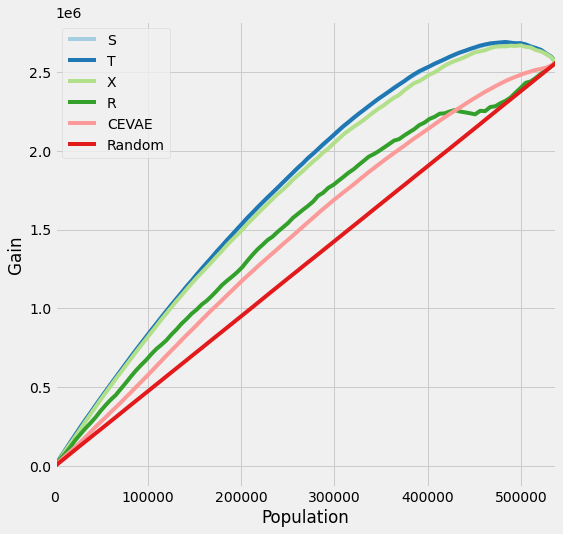

In [17]:
plot_gain(df_preds_train)

### Validation

In [18]:
df_preds_val = pd.DataFrame([s_ite_val.ravel(),
                             t_ite_val.ravel(),
                             x_ite_val.ravel(),
                             r_ite_val.ravel(),
                             ite_val.ravel(),
                             tau_val.ravel(),
                             treatment_val.ravel(),
                             y_val.ravel()],
                             index=['S','T','X','R','CEVAE','tau','w','y']).T

df_cumgain_val = get_cumgain(df_preds_val)

In [19]:
df_result_val = pd.DataFrame([s_ite_val.mean(), t_ite_val.mean(), x_ite_val.mean(), r_ite_val.mean(), ate_val, tau_val.mean()],
                              index=['S','T','X','R','CEVAE','actual'], columns=['ATE'])
df_result_val['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite_val, t_ite_val, x_ite_val, r_ite_val, ite_val],
                                                                  [tau_val.values.reshape(-1,1)]*5 )
                          ] + [None]
df_result_val['AUUC'] = auuc_score(df_preds_val)

In [20]:
df_result_val

,ATE,MAE,AUUC
S,4.690676,4.582191,0.683782
T,4.709923,4.717909,0.684032
X,4.560680,4.544644,0.671907
R,0.761550,5.997526,0.586110
CEVAE,0.595636,6.241192,0.566356
actual,4.774991,NaN,NaN


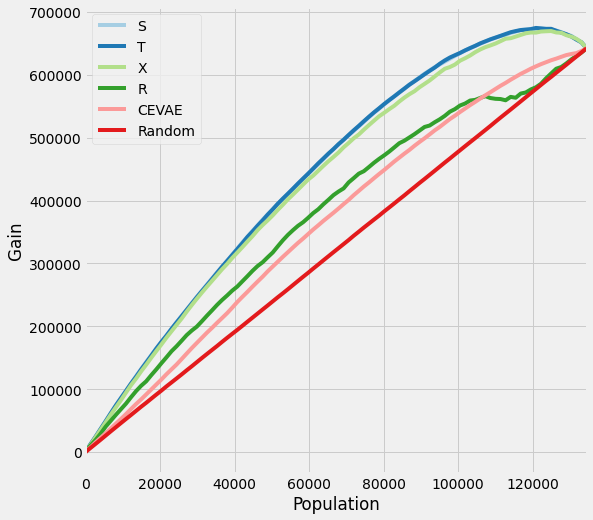

In [21]:
plot_gain(df_preds_val)

# Synthetic Data

In [23]:
y, X, w, tau, b, e = simulate_hidden_confounder(n=100000, p=5, sigma=1.0, adj=0.)

X_train, X_val, y_train, y_val, w_train, w_val, tau_train, tau_val, b_train, b_val, e_train, e_val = \
    train_test_split(X, y, w, tau, b, e, test_size=0.2, random_state=123, shuffle=True)

preds_dict_train = {}
preds_dict_valid = {}

preds_dict_train['Actuals'] = tau_train
preds_dict_valid['Actuals'] = tau_val

preds_dict_train['generated_data'] = {
    'y': y_train,
    'X': X_train,
    'w': w_train,
    'tau': tau_train,
    'b': b_train,
    'e': e_train}
preds_dict_valid['generated_data'] = {
    'y': y_val,
    'X': X_val,
    'w': w_val,
    'tau': tau_val,
    'b': b_val,
    'e': e_val}

# Predict p_hat because e would not be directly observed in real-life
p_model = ElasticNetPropensityModel()
p_hat_train = p_model.fit_predict(X_train, w_train)
p_hat_val = p_model.fit_predict(X_val, w_val)

for base_learner, label_l in zip([BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor],
                                 ['S', 'T', 'X', 'R']):
    for model, label_m in zip([LinearRegression, XGBRegressor], ['LR', 'XGB']):
        # RLearner will need to fit on the p_hat
        if label_l != 'R':
            learner = base_learner(model())
            # fit the model on training data only
            learner.fit(X=X_train, treatment=w_train, y=y_train)
            try:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, p=p_hat_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, p=p_hat_val).flatten()
            except TypeError:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, treatment=w_train, y=y_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, treatment=w_val, y=y_val).flatten()
        else:
            learner = base_learner(model())
            learner.fit(X=X_train, p=p_hat_train, treatment=w_train, y=y_train)
            preds_dict_train['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_train).flatten()
            preds_dict_valid['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_val).flatten()

# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 1e-3
learning_rate_decay = 0.1
num_layers = 3
num_samples = 10

cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers,
              num_samples=num_samples)

# fit
losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(w_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

preds_dict_train['CEVAE'] = cevae.predict(X_train).flatten()
preds_dict_valid['CEVAE'] = cevae.predict(X_val).flatten()

INFO 	 Training with 80 minibatches per epoch
DEBUG 	 step     0 loss = 14.0534
DEBUG 	 step     1 loss = 13.2864
DEBUG 	 step     2 loss = 13.0712
DEBUG 	 step     3 loss = 12.4646
DEBUG 	 step     4 loss = 12.0247
DEBUG 	 step     5 loss = 11.5239
DEBUG 	 step     6 loss = 11.2934
DEBUG 	 step     7 loss = 11.3141
DEBUG 	 step     8 loss = 10.8347
DEBUG 	 step     9 loss = 10.7364
DEBUG 	 step    10 loss = 10.5978
DEBUG 	 step    11 loss = 10.2533
DEBUG 	 step    12 loss = 10.131
DEBUG 	 step    13 loss = 10.0307
DEBUG 	 step    14 loss = 9.57977
DEBUG 	 step    15 loss = 9.79295
DEBUG 	 step    16 loss = 9.46927
DEBUG 	 step    17 loss = 9.57581
DEBUG 	 step    18 loss = 9.24119
DEBUG 	 step    19 loss = 9.34084
DEBUG 	 step    20 loss = 9.32529
DEBUG 	 step    21 loss = 9.40313
DEBUG 	 step    22 loss = 9.27057
DEBUG 	 step    23 loss = 9.05239
DEBUG 	 step    24 loss = 9.17952
DEBUG 	 step    25 loss = 8.93083
DEBUG 	 step    26 loss = 8.88059
DEBUG 	 step    27 loss = 9.06328
DEB

DEBUG 	 step   241 loss = 7.09788
DEBUG 	 step   242 loss = 6.98868
DEBUG 	 step   243 loss = 7.0711
DEBUG 	 step   244 loss = 7.10628
DEBUG 	 step   245 loss = 7.12893
DEBUG 	 step   246 loss = 6.94537
DEBUG 	 step   247 loss = 6.98222
DEBUG 	 step   248 loss = 7.12801
DEBUG 	 step   249 loss = 6.94684
DEBUG 	 step   250 loss = 7.01901
DEBUG 	 step   251 loss = 7.03228
DEBUG 	 step   252 loss = 7.14612
DEBUG 	 step   253 loss = 7.04241
DEBUG 	 step   254 loss = 6.92232
DEBUG 	 step   255 loss = 7.02093
DEBUG 	 step   256 loss = 6.98689
DEBUG 	 step   257 loss = 6.97682
DEBUG 	 step   258 loss = 6.99232
DEBUG 	 step   259 loss = 7.01528
DEBUG 	 step   260 loss = 6.86835
DEBUG 	 step   261 loss = 7.00633
DEBUG 	 step   262 loss = 7.06246
DEBUG 	 step   263 loss = 6.90189
DEBUG 	 step   264 loss = 7.07629
DEBUG 	 step   265 loss = 6.88559
DEBUG 	 step   266 loss = 6.92606
DEBUG 	 step   267 loss = 6.8929
DEBUG 	 step   268 loss = 6.83142
DEBUG 	 step   269 loss = 6.73955
DEBUG 	 step   2

DEBUG 	 batch ate = 0.822407
DEBUG 	 batch ate = 0.822365
DEBUG 	 batch ate = 0.825534
DEBUG 	 batch ate = 0.822151
DEBUG 	 batch ate = 0.823306


In [24]:
actuals_train = preds_dict_train['Actuals']
actuals_validation = preds_dict_valid['Actuals']

synthetic_summary_train = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_train)] for label, preds
                                        in preds_dict_train.items() if 'generated' not in label.lower()},
                                       index=['ATE', 'MSE']).T
synthetic_summary_train['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_train['ATE']/synthetic_summary_train.loc['Actuals', 'ATE']) - 1)

synthetic_summary_validation = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_validation)]
                                             for label, preds in preds_dict_valid.items()
                                             if 'generated' not in label.lower()},
                                            index=['ATE', 'MSE']).T
synthetic_summary_validation['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_validation['ATE']/synthetic_summary_validation.loc['Actuals', 'ATE']) - 1)

# calculate kl divergence for training
for label in synthetic_summary_train.index:
    stacked_values = np.hstack((preds_dict_train[label], actuals_train))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_train[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_train, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_train.loc[label, 'KL Divergence'] = kl

# calculate kl divergence for validation
for label in synthetic_summary_validation.index:
    stacked_values = np.hstack((preds_dict_valid[label], actuals_validation))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_valid[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_validation, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_validation.loc[label, 'KL Divergence'] = kl

In [25]:
df_preds_train = pd.DataFrame([preds_dict_train['S Learner (LR)'].ravel(),
                               preds_dict_train['S Learner (XGB)'].ravel(),
                               preds_dict_train['T Learner (LR)'].ravel(),
                               preds_dict_train['T Learner (XGB)'].ravel(),
                               preds_dict_train['X Learner (LR)'].ravel(),
                               preds_dict_train['X Learner (XGB)'].ravel(),
                               preds_dict_train['R Learner (LR)'].ravel(),
                               preds_dict_train['R Learner (XGB)'].ravel(),                               
                               preds_dict_train['CEVAE'].ravel(),
                               preds_dict_train['generated_data']['tau'].ravel(),
                               preds_dict_train['generated_data']['w'].ravel(),
                               preds_dict_train['generated_data']['y'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'CEVAE','tau','w','y']).T

synthetic_summary_train['AUUC'] = auuc_score(df_preds_train).iloc[:-1]

In [26]:
df_preds_validation = pd.DataFrame([preds_dict_valid['S Learner (LR)'].ravel(),
                               preds_dict_valid['S Learner (XGB)'].ravel(),
                               preds_dict_valid['T Learner (LR)'].ravel(),
                               preds_dict_valid['T Learner (XGB)'].ravel(),
                               preds_dict_valid['X Learner (LR)'].ravel(),
                               preds_dict_valid['X Learner (XGB)'].ravel(),
                               preds_dict_valid['R Learner (LR)'].ravel(),
                               preds_dict_valid['R Learner (XGB)'].ravel(),                               
                               preds_dict_valid['CEVAE'].ravel(),
                               preds_dict_valid['generated_data']['tau'].ravel(),
                               preds_dict_valid['generated_data']['w'].ravel(),
                               preds_dict_valid['generated_data']['y'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'CEVAE','tau','w','y']).T

synthetic_summary_validation['AUUC'] = auuc_score(df_preds_validation).iloc[:-1]

In [27]:
synthetic_summary_train

,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,0.726115,0.000000,0.000000,0.000000,NaN
S Learner (LR),0.832336,0.062462,0.146287,6.278413,0.499991
S Learner (XGB),0.807743,0.039735,0.112417,2.551297,0.554885
T Learner (LR),0.833364,0.059665,0.147703,3.312696,0.523272
T Learner (XGB),0.803592,0.040524,0.106701,2.565715,0.553197
X Learner (LR),0.833364,0.059665,0.147703,3.312696,0.523272
X Learner (XGB),0.803349,0.038580,0.106367,2.500947,0.555391
R Learner (LR),0.833845,0.060239,0.148365,3.511157,0.523214
R Learner (XGB),0.735442,0.046848,0.012845,2.836128,0.539213
CEVAE,0.822853,0.058177,0.133227,3.157059,0.519150


In [28]:
synthetic_summary_validation

,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,0.728371,0.000000,0.000000,0.000000,NaN
S Learner (LR),0.832336,0.061983,0.142736,6.278413,0.499967
S Learner (XGB),0.808844,0.040638,0.110483,2.548714,0.553011
T Learner (LR),0.833805,0.059305,0.144753,3.316884,0.522972
T Learner (XGB),0.803766,0.042424,0.103512,2.561688,0.549279
X Learner (LR),0.833805,0.059305,0.144753,3.316884,0.522972
X Learner (XGB),0.803530,0.039699,0.103187,2.489822,0.553039
R Learner (LR),0.834179,0.059851,0.145266,3.512746,0.522887
R Learner (XGB),0.736147,0.046685,0.010675,2.747596,0.536579
CEVAE,0.823373,0.057690,0.130430,3.152161,0.519573


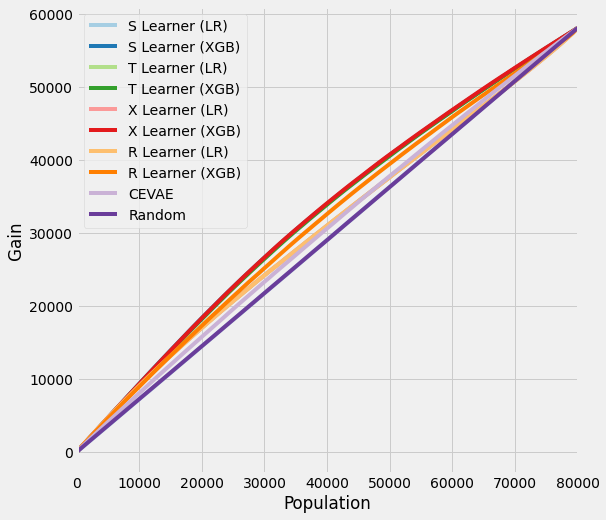

In [29]:
plot_gain(df_preds_train)

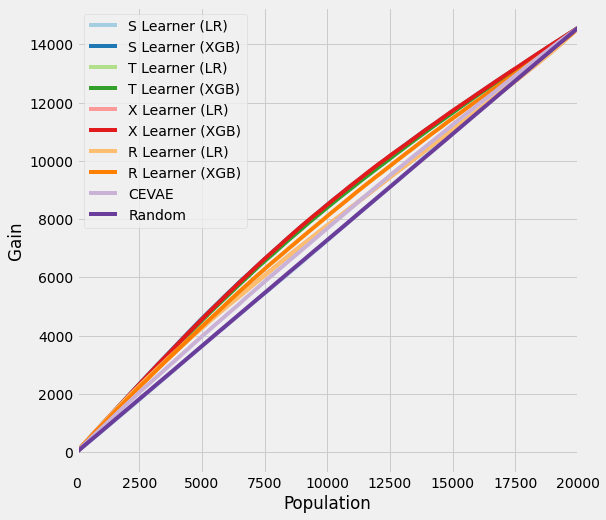

In [30]:
plot_gain(df_preds_validation)